In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from nn.UNet import UNet
import torch as th
from torchvision import transforms
from skimage.measure import label, regionprops
import tifffile
from skimage.morphology import disk, binary_erosion, binary_dilation, binary_opening, binary_closing
import seaborn as sns
import matplotlib.cm as cm

In [22]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
model = UNet(1, 1).to(device)
model.load_state_dict(th.load("/home/quantum/MScThesisCode/unet.th", weights_only=True))
model.eval()
transform = transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])

img = th.from_numpy(np.astype(tifffile.imread("/mnt/d/d1/AB-TGF/15_D6.tif")[-1], np.float32)).unsqueeze(0).unsqueeze(0).to(device)
segm = model(img)
segm_bin = ((th.sigmoid(segm) > 0.5).long().detach().squeeze().cpu().numpy())

In [30]:
disk_sizes = [1, 3, 5, 7]
operations = {
    "Erosion": binary_erosion,
    "Dilation": binary_dilation,
    "Opening": binary_opening,
    "Closing": binary_closing
}

# Store results
results = {}

for op_name, op_func in operations.items():
    results[op_name] = []
    for d in disk_sizes:
        processed = op_func(segm_bin, disk(d))
        labeled = label(processed)
        regions = regionprops(labeled)
        areas = [r.area for r in regions]
        largest_region = max(regions, key=lambda r: r.area, default=None)
        results[op_name].append((d, areas, processed, largest_region))

/tmp/ipykernel_1857/2007750648.py:7: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(data=areas, ax=axes[i], palette=pastel_palette, log_scale=True)
/tmp/ipykernel_1857/2007750648.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(sizes)
/tmp/ipykernel_1857/2007750648.py:7: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(data=areas, ax=axes[i], palette=pastel_palette, log_scale=True)
/tmp/ipykernel_1857/2007750648.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(sizes)
/tmp/ipykernel_1857/2007750648.py:7: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(data=areas, ax=axes[i], palette=pastel

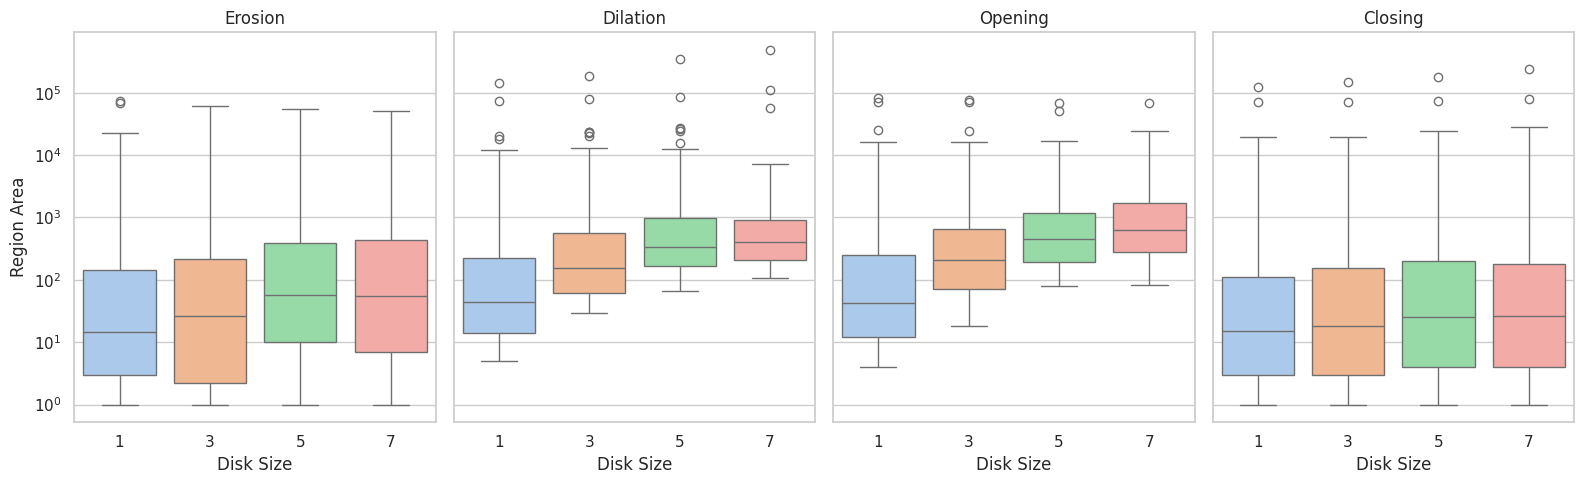

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)
sns.set_theme(style="whitegrid")
pastel_palette = sns.color_palette("pastel")

for i, (op_name, data) in enumerate(results.items()):
    sizes, areas, _, _ = zip(*data)
    sns.boxplot(data=areas, ax=axes[i], palette=pastel_palette, log_scale=True)
    axes[i].set_xticklabels(sizes)
    axes[i].set_title(op_name)
    axes[i].set_xlabel("Disk Size")
    if i == 0:
        axes[i].set_ylabel("Region Area")

plt.tight_layout()
plt.savefig("Morphology_Boxplot.png")
plt.show()


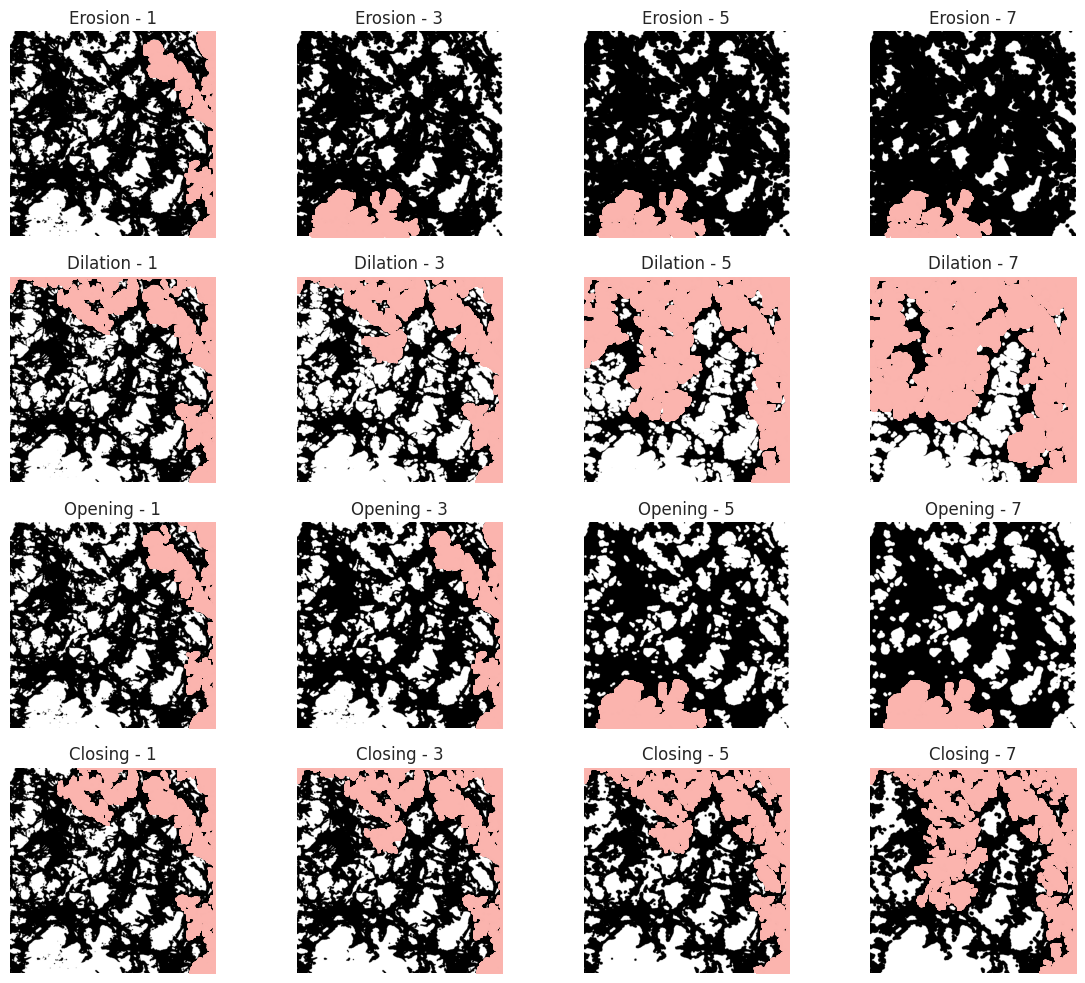

In [32]:
fig, axes = plt.subplots(len(operations), len(disk_sizes), figsize=(12, 10))
pastel_colors = cm.Pastel1(np.linspace(0, 1, 1))

for i, (op_name, data) in enumerate(results.items()):
    for j, (_, _, processed, largest_region) in enumerate(data):
        ax = axes[i, j]
        ax.imshow(processed, cmap="gray")
        
        # Highlight the largest region
        if largest_region:
            coords = largest_region.coords
            ax.scatter(coords[:, 1], coords[:, 0], s=1, color=pastel_colors[0], alpha=0.7)
        
        ax.set_title(f"{op_name} - {disk_sizes[j]}")
        ax.axis("off")

plt.tight_layout()
plt.savefig("Morphology_Segmentation.png")
plt.show()